Playing with the Generative Adversarial Network (GAN) in a few simple settings.

In [1]:
import matplotlib.pyplot as pp
import numpy as np
import tensorflow as tf
import contextlib
import os
import struct
%matplotlib inline

In [2]:
seed = 62585
np.random.seed(seed)
tf.set_random_seed(seed)

For collecting the variables defined during a code span.

In [3]:
@contextlib.contextmanager
def VariableDiff():
  v0 = set(tf.trainable_variables())
  vdiff = []
  yield vdiff
  v1 = tf.trainable_variables()
  for v in v1:
    if v not in v0:
      vdiff.append(v)

Fa(v) is g(v) and Fb(v) is f*(g(v)), respectively, in the [f-gan paper](https://arxiv.org/pdf/1606.00709.pdf).

In [4]:
class GanKL(object):
  def Fa(self, v):
    return v
  
  def Fb(self, v):
    return -tf.exp(v - 1.0)
  
  def FbMFa(self, v):
    return self.Fb(v) - self.Fa(v)
  
class GanPlain(GanKL):
  def Fa(self, v):
    return tf.log_sigmoid(v)
  
  def Fb(self, v):
    return self.Fa(v) - v
  
  def FbMFa(self, v):
    return -v
  
class GanJS(GanKL):
  def Fa(self, v):
    return tf.log_sigmoid(v) + tf.log(2.0)
  
  def Fb(self, v):
    return self.Fa(v) - v
  
  def FbMFa(self, v):
    return -v
  
class GanRevKL(GanKL):
  def Fa(self, v):
    return -tf.exp(-v)
  
  def Fb(self, v):
    return 1.0 - v

In [5]:
sess = tf.Session(config=tf.ConfigProto(device_count={"GPU": 0}))

In [6]:
global_step = tf.train.get_or_create_global_step()
learn_rate = tf.constant(0.01, dtype=tf.float32, shape=[])
batch_size = tf.constant(8, dtype=tf.int32, shape=[])

In [7]:
class ModelNormalToUniform(object):
  def Generate(self, z):
    with VariableDiff() as vars_gen:
      h = z
      h = tf.layers.dense(h, 128, activation=tf.tanh)

      h1 = tf.layers.dense(h, 128, activation=tf.tanh)
      h = tf.layers.dense(h1, 128) + h

      h1 = tf.layers.dense(h, 128, activation=tf.tanh)
      h = tf.layers.dense(h1, 128) + h

      h = tf.layers.dense(h, self.dim)
    self.vars_gen = vars_gen
    return h

  def Discriminate(self, y):
    with VariableDiff() as vars_dis:
      h = y
      h = tf.layers.dense(h, 128, activation=tf.tanh)

      h1 = tf.layers.dense(h, 128, activation=tf.tanh)
      h = tf.layers.dense(h1, 128) + h

      h1 = tf.layers.dense(h, 128, activation=tf.tanh)
      h = tf.layers.dense(h1, 128) + h

      h = tf.layers.dense(h, 1)    
    self.vars_dis = vars_dis
    return h
      
  def _CreateLatent(self):
    z = tf.random_normal([batch_size, self.dim])
    return z
  
  def _CreateObserved(self):
    yd = tf.random_uniform([batch_size, self.dim])
    return yd
      
  def __init__(self):
    self.dim = 1
    self._CreateModel()
    
  def _CreateModel(self):
    z = self._CreateLatent()
    self.z = z

    ys = self.Generate(z)
    yd = self._CreateObserved()
    y = tf.concat([yd, ys], axis=0)
    self.yd, self.ys = yd, ys
    self.y = y
    
    p = self.Discriminate(y)
    self.p = p
    self.sig_p = tf.sigmoid(p)
    pd, ps = tf.split(p, 2, axis=0)
    self.pd, self.ps = pd, ps
    
  def Plot(self):
    ys_v, yd_v = sess.run([self.ys, self.yd])
    pp.hist(np.concatenate([ys_v, yd_v], axis=1))

    x0, x1 = pp.xlim()
    y0, y1 = pp.ylim()
    batch_size_v = sess.run(batch_size)
    
    y_v = np.expand_dims(np.linspace(x0, x1, batch_size_v * 2), 1)
    sig_p_v = sess.run(self.sig_p, {self.y: y_v})
    pp.plot(y_v, sig_p_v * (y1 - y0) + y0)
    
  def Verify(self):
    ys_v_all = []
    while len(ys_v_all) < 12800:
      ys_v = sess.run(self.ys)
      ys_v_all.extend(list(ys_v[:, 0]))
    pp.hist(ys_v_all, bins=30)      
    
  @property
  def inputs(self):
    return [self.yd, self.ys]

In [8]:
class ModelNormalToTwoUnifs(ModelNormalToUniform):   
  def _CreateObserved(self):
    yd1 = tf.random_uniform([batch_size / 2, 1], minval=1.0, maxval=2.0)
    yd2 = tf.random_uniform([batch_size / 2, 1], minval=-3.0, maxval=-1.0)
    yd = tf.concat([yd1, yd2], axis=0)
    return yd

In [9]:
class ModelNormalToNormal(ModelNormalToUniform):   
  def _CreateObserved(self):
    yd = tf.random_normal([batch_size, self.dim])
    return yd

In [10]:
class ModelNormalToUniform2D(ModelNormalToUniform):
  def __init__(self):
    self.dim = 2
    self._CreateModel()  
    
  def Plot(self):
    ys_v, yd_v = sess.run([self.ys, self.yd])
    pp.plot(ys_v[:, 0], ys_v[:, 1], ".")
    pp.plot(yd_v[:, 0], yd_v[:, 1], ".")
    
  def Verify(self):
    yd_v_all, ys_v_all = sess.run([self.yd, self.ys])
    for i in range(100):
      yd_v, ys_v = sess.run([self.yd, self.ys])
      yd_v_all = np.concatenate([yd_v_all, yd_v], axis=0)
      ys_v_all = np.concatenate([ys_v_all, ys_v], axis=0)
    pp.plot(ys_v_all[:, 0], ys_v_all[:, 1], ".")
    pp.plot(yd_v_all[:, 0], yd_v_all[:, 1], ".")

In [11]:
class ModelNormalToLine(ModelNormalToUniform2D):
  def __init__(self):
    self.dim = 2
    self._CreateModel()  
    
  def _CreateObserved(self):
    yd = tf.random_uniform([batch_size, 1], minval=0.0, maxval=1.0)
    yd = tf.concat([yd, 1.0 - yd], axis=1)
    return yd

The modeling code taken from
http://blog.aylien.com/introduction-generative-adversarial-networks-code-tensorflow/

Except that discriminator is made twice wider.

In [12]:
class ModelNormalToNormalAylien(ModelNormalToNormal):
  def Generate(self, z):
    with VariableDiff() as vars_gen:
      h_dim = 4
      h = z
      h = tf.layers.dense(h, h_dim, activation=tf.nn.softplus)
      h = tf.layers.dense(h, self.dim)
    self.vars_gen = vars_gen
    return h
  
  def Discriminate(self, y):
    with VariableDiff() as vars_dis:
      # h_dim = 4
      h_dim = 8
      use_minibatch = True
      
      h = y
      
      h = tf.layers.dense(h, h_dim * 2, activation=tf.nn.relu)
      h = tf.layers.dense(h, h_dim * 2, activation=tf.nn.relu)
      
      if use_minibatch:
        h = self.Minibatch(h)
      else:
        h = tf.layers.dense(h, h_dim * 2, activation=tf.nn.relu)

      h = tf.layers.dense(h, 1)
    self.vars_dis = vars_dis
    return h
  
  def Minibatch(self, h, num_kernels=5, kernel_dim=3):
    x = tf.layers.dense(h, num_kernels * kernel_dim)
    
    activation = tf.reshape(x, (-1, num_kernels, kernel_dim))
    diffs = (tf.expand_dims(activation, 3) - 
             tf.expand_dims(tf.transpose(activation, [1, 2, 0]), 0))
    abs_diffs = tf.reduce_sum(tf.abs(diffs), 2)
    minibatch_features = tf.reduce_sum(tf.exp(-abs_diffs), 2)
    return tf.concat([h, minibatch_features], 1)
    
  
class ModelNormalToUniformAylien(ModelNormalToNormalAylien):
  def _CreateObserved(self):
    yd = tf.random_uniform([batch_size, self.dim])
    return yd  

In [13]:
# Implicit GAN means that D step minimizes sigmoid_cross_entropy_with_logits
# and G step maximizes it, with respect to discriminator and generator
# respectively.
class TrainImplicitGanSingleStep(object):
  def __init__(self, model, opt_cls=tf.train.GradientDescentOptimizer):
    self.m = model
    self.opt = opt_cls(learn_rate)

    labels = tf.concat([
        tf.ones(shape=[tf.shape(self.m.pd)[0], 1]), 
        tf.zeros(shape=[tf.shape(self.m.ps)[0], 1]),
    ], axis=0)

    loss0_dis = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=self.m.p, labels=labels))
    self.loss = loss0_dis
    self._CreateTrainOps()

  def _CreateTrainOps(self):
    vars_all = tf.trainable_variables()
    y_grad, = tf.gradients(self.loss, self.m.y)
    grads0_s = tf.gradients(
        [self.loss, self.m.y], 
        vars_all, 
        [tf.ones_like(self.loss), y_grad * (-2.0)],
    )
    train0_s = self.opt.apply_gradients(
        zip(grads0_s, vars_all), 
        global_step=global_step,
    )
    self.train_op = train0_s

  def Step(self, feed_dict=None, dsteps=1, gsteps=1):
    sess.run([self.train_op], feed_dict)
  
class TrainImplicitGanTwoSteps(TrainImplicitGanSingleStep):
  def _CreateTrainOps(self):
    vars_all = tf.trainable_variables()
    y_grad, = tf.gradients(self.loss, self.m.y)
    grads0_d = tf.gradients([self.loss, self.m.y], vars_all, [tf.ones_like(self.loss), y_grad * (-1.0)])
    grads0_g = tf.gradients([self.m.y], vars_all, [y_grad * (-1.0)])
    train0_d = self.opt.apply_gradients(zip(grads0_d, vars_all))
    train0_g = self.opt.apply_gradients(zip(grads0_g, vars_all), global_step=global_step)
    self.train_d = train0_d
    self.train_g = train0_g
  
  def Step(self, feed_dict=None, dsteps=1, gsteps=1):
    for i in range(dsteps):
      sess.run(self.train_d, feed_dict)
    for i in range(gsteps):
      sess.run(self.train_g, feed_dict)
  
class TrainGanSingleTwoSteps1(TrainImplicitGanTwoSteps):
  def __init__(self, model, gan_cls=GanPlain, opt_cls=tf.train.GradientDescentOptimizer):
    self.m = model
    self.gan_cls = gan_cls
    self.opt = opt_cls(learn_rate)
    self._CreateTrainOps()
  
  def _CreateTrainOps(self):
    gan = self.gan_cls()

    loss_fad = tf.reduce_mean(gan.Fa(self.m.pd))
    loss_fbs = tf.reduce_mean(gan.Fb(self.m.ps))
    self.loss = (loss_fad + loss_fbs) * (-0.5)

    train_d = self.opt.minimize(
        - loss_fad - loss_fbs, 
        var_list=self.m.vars_dis, 
    )
    train_g1 = self.opt.minimize(
        loss_fbs, 
        var_list=self.m.vars_gen, 
        global_step=global_step
    )
    self.train_d = train_d
    self.train_g = train_g1
    
class TrainGanSingleTwoSteps2(TrainGanSingleTwoSteps1):
  def _CreateTrainOps(self):
    gan = self.gan_cls()

    loss_fad = tf.reduce_mean(gan.Fa(self.m.pd))
    loss_fbs = tf.reduce_mean(gan.Fb(self.m.ps))
    loss_fas = tf.reduce_mean(gan.Fa(self.m.ps))
    self.loss = (loss_fad + loss_fbs) * (-0.5)

    train_d = self.opt.minimize(
        - loss_fad - loss_fbs, 
        var_list=self.m.vars_dis, 
    )
    train_g2 = self.opt.minimize(
        -loss_fas, 
        var_list=self.m.vars_gen,
        global_step=global_step
    )
    self.train_d = train_d
    self.train_g = train_g2    
    
class TrainGanSingleTwoSteps3(TrainGanSingleTwoSteps1):
  def _CreateTrainOps(self):
    gan = self.gan_cls()

    loss_fad = tf.reduce_mean(gan.Fa(self.m.pd))
    loss_fbs = tf.reduce_mean(gan.Fb(self.m.ps))
    loss_fcs = tf.reduce_mean(gan.FbMFa(self.m.ps))
    self.loss = (loss_fad + loss_fbs) * (-0.5)

    train_d = self.opt.minimize(
        - loss_fad - loss_fbs, 
        var_list=self.m.vars_dis, 
    )
    train_g3 = self.opt.minimize(
        loss_fcs, 
        var_list=self.m.vars_gen,
        global_step=global_step
    )
    self.train_d = train_d
    self.train_g = train_g3
    
class TrainGanSingleTwoSteps3SameBatch(TrainGanSingleTwoSteps3):
  def Step(self, feed_dict=None, dsteps=1, gsteps=1):
      
    inputs = self.m.inputs
    inputs_v = sess.run(inputs, feed_dict)
    
    if feed_dict is None:
      feed_dict = {}
      
    same_feeds = dict(zip(inputs, inputs_v))
    same_feeds.update(feed_dict)
    
    for i in range(dsteps):
      sess.run(self.train_d, same_feeds)
    for i in range(gsteps):
      sess.run(self.train_g, same_feeds)  
    
class TrainGanSingleTwoSteps3SepOpt(TrainGanSingleTwoSteps1):
  def _CreateTrainOps(self):
    gan = self.gan_cls()

    loss_fad = tf.reduce_mean(gan.Fa(self.m.pd))
    loss_fbs = tf.reduce_mean(gan.Fb(self.m.ps))
    loss_fcs = tf.reduce_mean(gan.FbMFa(self.m.ps))
    self.loss = (loss_fad + loss_fbs) * (-0.5)

    opt_d = tf.train.GradientDescentOptimizer(learn_rate)
    opt_g = tf.train.AdamOptimizer(learn_rate)
    train_d = opt_d.minimize(
        - loss_fad - loss_fbs, 
        var_list=self.m.vars_dis, 
    )
    train_g3 = opt_g.minimize(
        loss_fcs, 
        var_list=self.m.vars_gen,
        global_step=global_step
    )
    self.train_d = train_d
    self.train_g = train_g3    

In [14]:
# m = ModelNormalToUniform()
# m = ModelNormalToNormal()
# m = ModelNormalToNormalAylien()
m = ModelNormalToUniformAylien()
# m = ModelNormalToTwoUnifs()
# m = ModelNormalToUniform2D()
# m = ModelNormalToLine()

The choice of gan classes doesn't seem to have a difference in the 1d normal-to-uniform experiment.

In [15]:
# gan_cls = GanPlain
# gan_cls = GanJS
gan_cls = GanKL
# gan_cls = GanRevKL

In [16]:
opt_cls = tf.train.AdamOptimizer
# opt_cls = tf.train.GradientDescentOptimizer

In [17]:
# t = TrainGanSingleTwoSteps3(m, gan_cls=gan_cls, opt_cls=opt_cls)
# t = TrainGanSingleTwoSteps3SameBatch(m, gan_cls=gan_cls, opt_cls=opt_cls)
t = TrainGanSingleTwoSteps2(m, gan_cls=gan_cls, opt_cls=opt_cls)
# t = TrainGanSingleTwoSteps1(m, gan_cls=gan_cls, opt_cls=opt_cls)
# t = TrainImplicitGanSingleStep(m, opt_cls=opt_cls)
# t = TrainImplicitGanTwoSteps(m, opt_cls=opt_cls)
# t = TrainGanSingleTwoSteps3SepOpt(m, gan_cls=gan_cls, opt_cls=opt_cls)

In [18]:
init_op = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())

In [19]:
sess.run(init_op)

[15000, -0.0080958605]


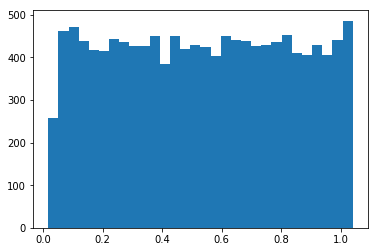

In [20]:
for i in range(15000):
  t.Step({learn_rate: 0.001})

pp.figure()
m.Verify()
print(sess.run([global_step, t.loss]))